In [1]:
import sys
sys.path.append("../") # adding the path to read the utils file
from sklearnex import patch_sklearn
patch_sklearn(global_patch=True)
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics, tree
from shap import TreeExplainer
import fasttreeshap
from shap import plots, Explanation
import graphviz 
from yellowbrick.model_selection import LearningCurve
import time
import shap
from utils import *
import pickle

pd.set_option('display.max_columns', None)

Scikit-learn was successfully globally patched by Intel(R) Extension for Scikit-learn


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
ds = pd.read_parquet("../datasets/CICIDS-2017.parquet")
ds.head()

,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Fwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Attack
0,6.0,1266342.0,41.0,44.0,2664.0,6954.0,456.0,0.0,64.975609,109.864571,976.0,0.0,158.045456,312.675262,7595.104640,67.122468,15075.50000,104051.399700,948537.0,0.0,1266342.0,31658.550,159355.2595,996324.0,2.0,317671.0,7387.697674,19636.44809,104616.0,1.0,0.0,0.0,1328.0,1424.0,32.376720,34.745748,0.0,976.0,111.837212,239.686844,57449.78495,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,113.152939,64.975609,158.045456,41.0,2664.0,44.0,6954.0,29200.0,243.0,24.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN,False
1,6.0,1319353.0,41.0,44.0,2664.0,6954.0,456.0,0.0,64.975609,109.864571,976.0,0.0,158.045456,312.675262,7289.936810,64.425518,15706.58333,104861.870100,955790.0,1.0,1319353.0,32983.825,159247.9008,996423.0,1.0,363429.0,8451.837209,21337.26261,104815.0,1.0,0.0,0.0,1328.0,1424.0,31.075838,33.349680,0.0,976.0,111.837212,239.686844,57449.78495,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,113.152939,64.975609,158.045456,41.0,2664.0,44.0,6954.0,29200.0,243.0,24.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN,False
2,6.0,160.0,1.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,12500.000000,160.00000,0.000000,160.0,160.0,0.0,0.000,0.0000,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,32.0,32.0,6250.000000,6250.000000,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,1.0,0.0,1.0,0.0,290.0,243.0,0.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN,False
3,6.0,1303488.0,41.0,42.0,2728.0,6634.0,456.0,0.0,66.536583,110.129944,976.0,0.0,157.952377,319.121429,7182.267884,63.675308,15896.19512,106554.899000,956551.0,0.0,1303488.0,32587.200,160397.0499,997357.0,1.0,346851.0,8459.780488,23962.23892,138295.0,0.0,0.0,0.0,1328.0,1360.0,31.454068,32.221240,0.0,976.0,111.452377,241.642792,58391.23867,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,112.795181,66.536583,157.952377,41.0,2728.0,42.0,6634.0,29200.0,243.0,24.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN,False
4,6.0,77.0,1.0,2.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,38961.038960,38.50000,14.849242,49.0,28.0,0.0,0.000,0.0000,0.0,0.0,49.0,49.000000,0.00000,49.0,49.0,0.0,0.0,32.0,64.0,12987.012990,25974.025970,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.000000,0.000000,0.000000,1.0,0.0,2.0,0.0,243.0,290.0,0.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN,False


We can see from this graph that we don't have highly correlated features.

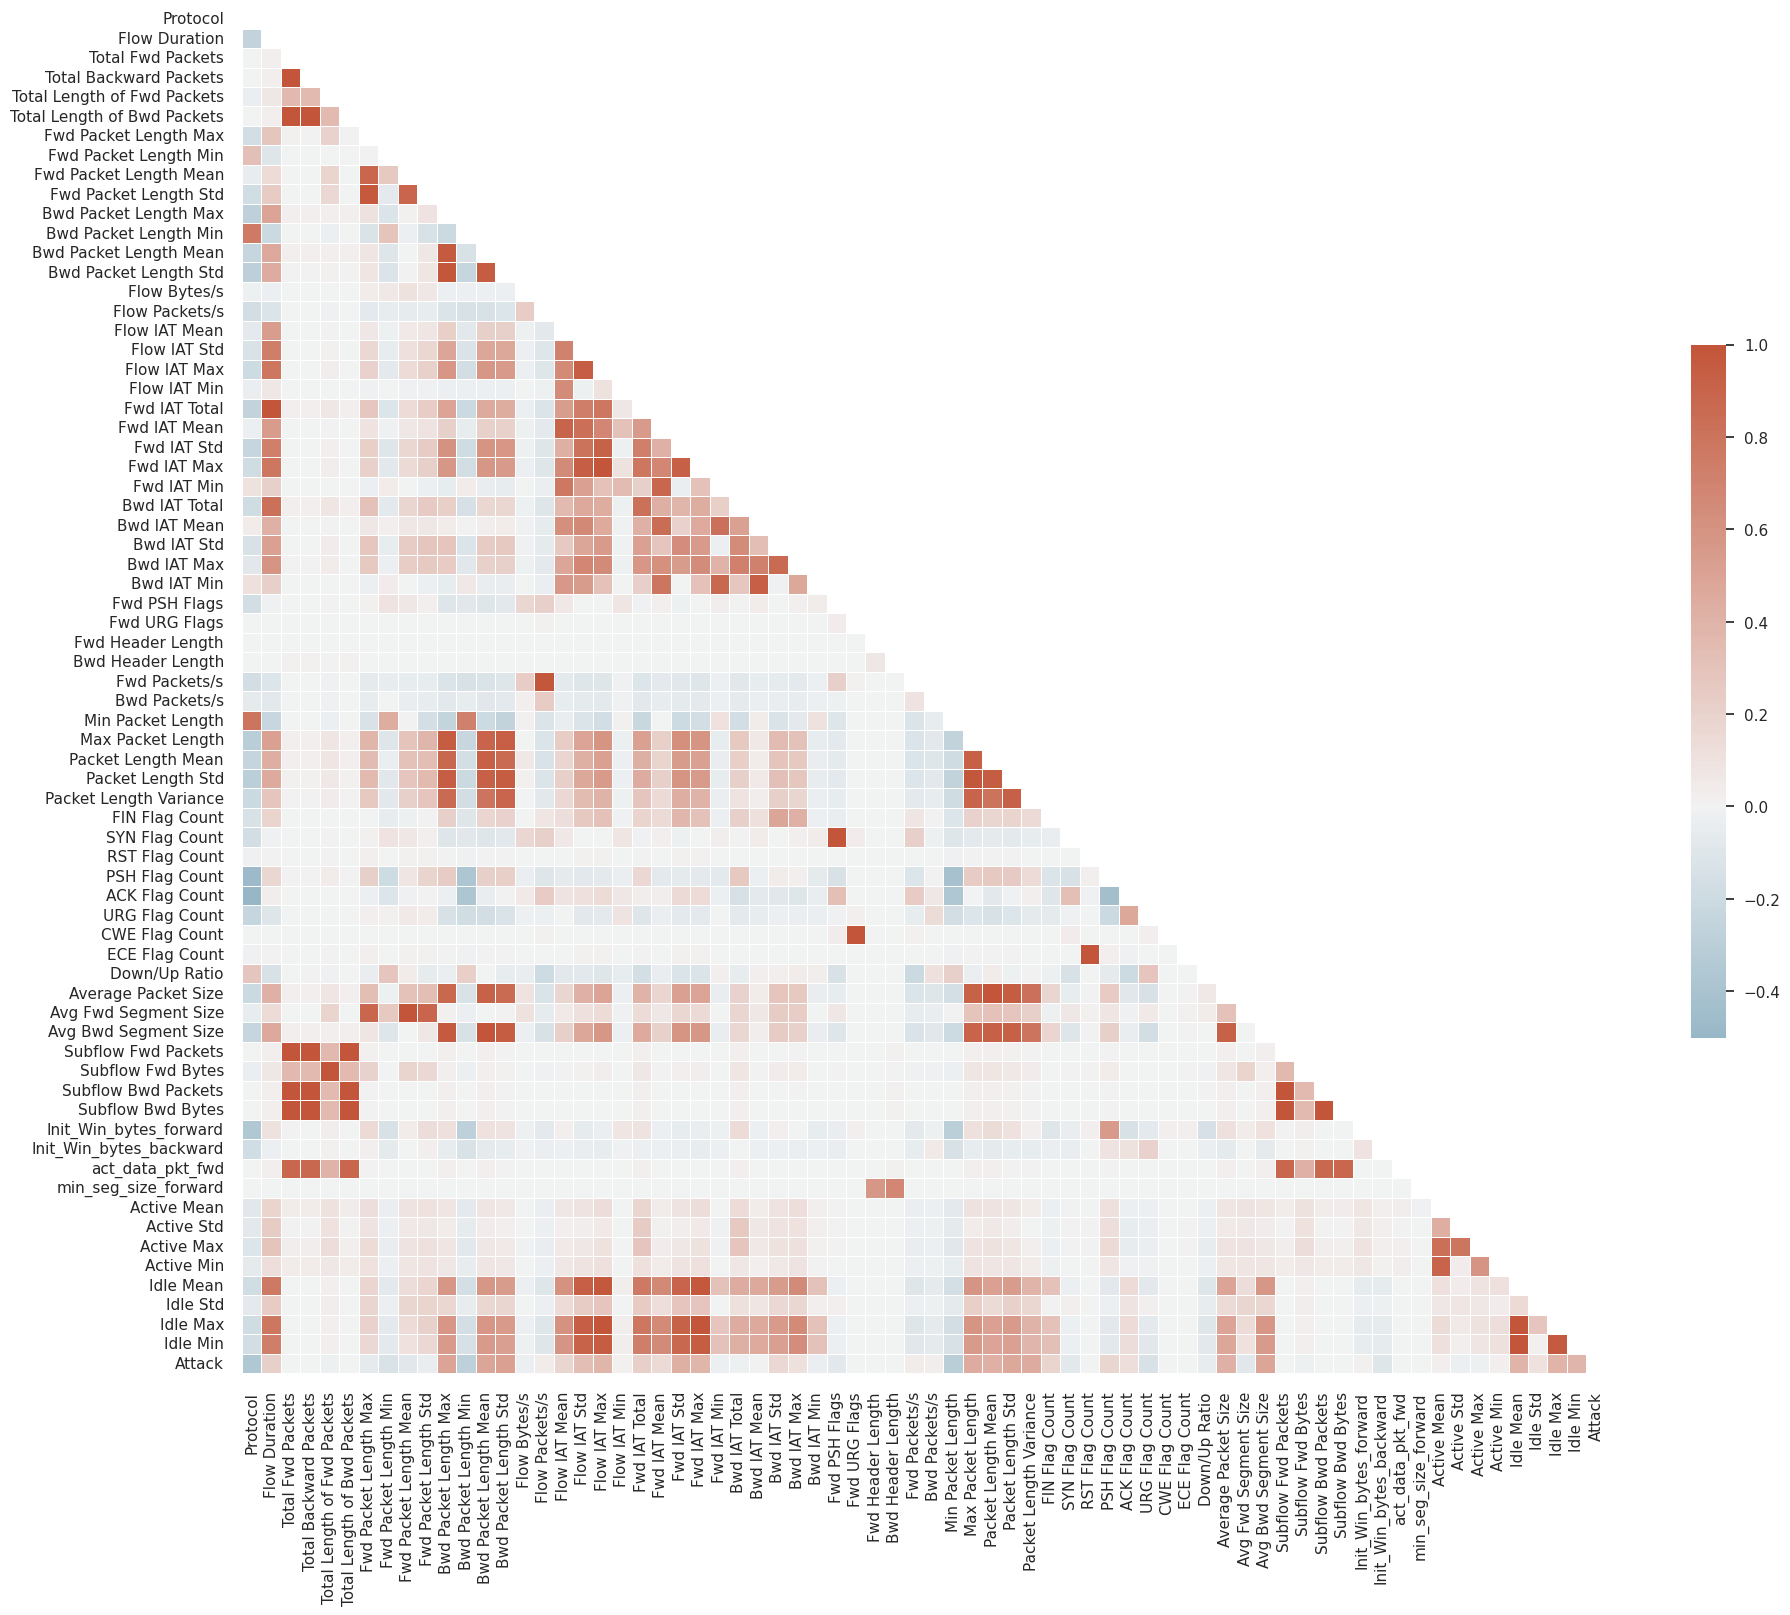

In [3]:
show_corr_matrix(ds)

In [4]:
compute_ratio(ds,'Label')

                           Ratio
Label                           
BENIGN                     80.32
DoS Hulk                    8.14
PortScan                    5.62
DDoS                        4.53
DoS GoldenEye               0.36
FTP-Patator                 0.28
SSH-Patator                 0.21
DoS slowloris               0.20
DoS Slowhttptest            0.19
Bot                         0.07
Web Attack  Brute Force     0.05
Web Attack  XSS             0.02
Infiltration                0.00
Web Attack  Sql Injection   0.00
Heartbleed                  0.00


In [5]:
ds.Label.value_counts()

Label
BENIGN                       2271122
DoS Hulk                      230123
PortScan                      158804
DDoS                          128025
DoS GoldenEye                  10293
FTP-Patator                     7935
SSH-Patator                     5897
DoS slowloris                   5796
DoS Slowhttptest                5499
Bot                             1956
Web Attack  Brute Force         1507
Web Attack  XSS                  652
Infiltration                      36
Web Attack  Sql Injection         21
Heartbleed                        11
Name: count, dtype: int64

In [ ]:
params = {
    "n_jobs": -1, 
    "n_estimators": 5,
    "max_depth": 14,
    "random_state": 42,
    "max_features": len(x_features)
}

In [ ]:
rf = RandomForestClassifier(**params)
pv = DataPreprocessingAndValidation(ds, 7988, 5, RandomForestClassifier, params)

In [ ]:
X_res, y_res = pv.get_undersampled_ds()
X_train, X_test, y_train, y_test = train_test_split(X_res, ds.loc[y_res.index].Label, test_size = 0.2, random_state=12,  stratify=y_res)

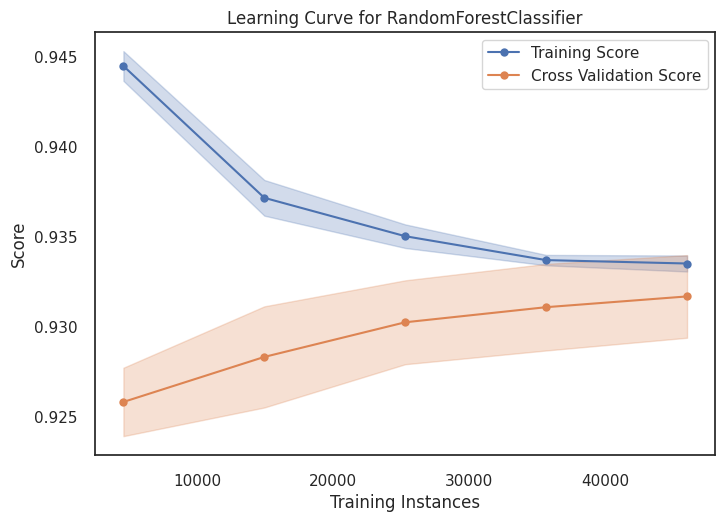

In [ ]:
if True:
    cv = 10
    visualizer = LearningCurve(estimator=rf, cv=cv, scoring='f1', n_jobs=1, random_state=123)
    visualizer.fit(X_train, y_train)
    visualizer.show(outpath="rf_data/learning_curve.png")


![Alt text](rf_data/learning_curve.png)

In [ ]:
%time pv.cross_validation(ds[x_features], ds.Label, y_res)

Running the stratified 5-fold
Test and Train k-fold created
Running the cross validation
CPU times: user 38.6 s, sys: 163 ms, total: 38.7 s
Wall time: 9.86 s


(0.9316216682695144, 0.0018058602161641069, 9.525866508483887)

In [ ]:
%time rf.fit(X_train, y_train)

CPU times: user 7.52 s, sys: 3.97 ms, total: 7.52 s
Wall time: 1.73 s


RandomForestClassifier(max_depth=14, max_features=79, n_estimators=5, n_jobs=-1,
                       random_state=42)

In [ ]:
%time y_predicted_train = rf.predict(X_train)
%time y_predicted_test = rf.predict(X_test)

CPU times: user 49.7 ms, sys: 0 ns, total: 49.7 ms
Wall time: 29.6 ms
CPU times: user 18.8 ms, sys: 0 ns, total: 18.8 ms
Wall time: 18.7 ms


In [ ]:
performanceMetricsDF(metrics, y_train, y_predicted_train, y_test, y_predicted_test)

,Measure,Train,Test
0,ACCURACY,0.928760,0.926610
1,PRECISION,0.875544,0.874057
2,RECALL,0.999609,0.996871
3,F1 SCORE,0.933472,0.931433
4,AUC,0.928761,0.926604


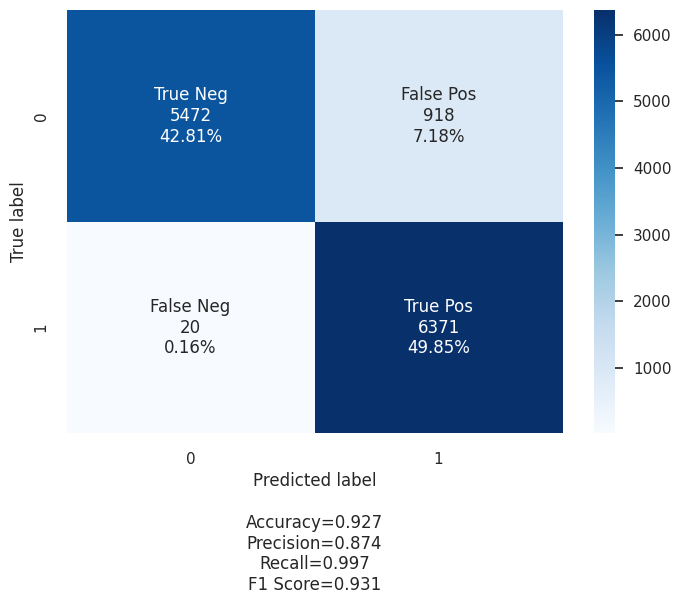

In [ ]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_predicted_test)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['0', '1']
make_confusion_matrix(cf, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

In [ ]:
for num, clf in enumerate(rf.estimators_):
    print(clf.get_depth())

14
14
14
14
14


In [ ]:
for num, clf in enumerate(rf.estimators_):
    dot_data = tree.export_graphviz(clf, feature_names=x_features, out_file=None, ) 
    graph = graphviz.Source(dot_data)
    graph.render('tree/tree_rf_' + str(num))

In [ ]:
start_time = time.time()
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.016 seconds


Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


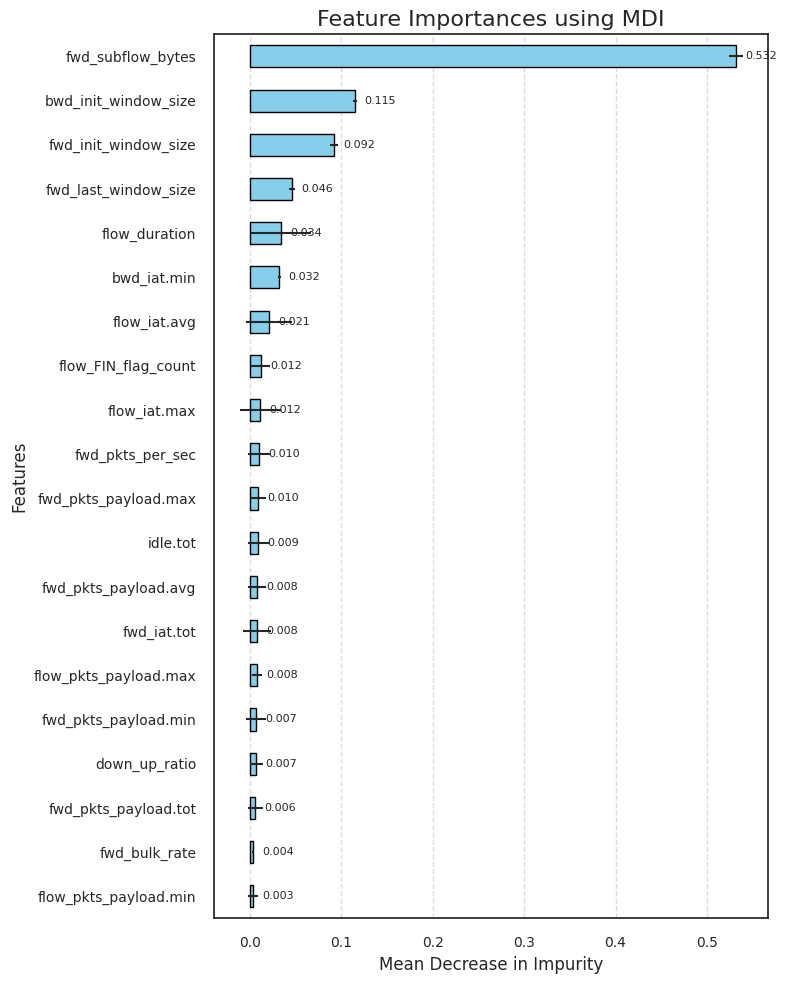

In [ ]:
forest_importances = pd.Series(importances, index=x_features)

sorted_indices = np.argsort(forest_importances)[::-1]
sorted_std = std[sorted_indices][:20] # Select only the first 20 features
sorted_importance = forest_importances[sorted_indices][:20]  # Select importance values for the first 20 features

# Create the figure and axis
fig, ax = plt.subplots(figsize=(8, 10))  # Adjust the figure size as needed for vertical display

# Create the vertical bar plot with error bars
sorted_importance.plot(kind='barh', xerr=sorted_std, ax=ax, color='skyblue', edgecolor='black')

# Set plot title and labels
ax.set_title("Feature Importances using MDI", fontsize=16)
ax.set_xlabel("Mean Decrease in Impurity", fontsize=12)
ax.set_ylabel("Features", fontsize=12)

# Customize ticks and grid
ax.tick_params(axis='both', which='major', labelsize=10)
ax.grid(axis='x', linestyle='--', alpha=0.7)

# Invert y-axis to display most important feature at the top
ax.invert_yaxis()

# Add data labels at the end of each bar
for i, v in enumerate(sorted_importance):
    ax.text(v + 0.01, i, f'{v:.3f}', va='center', fontsize=8)

# Show the plot
plt.tight_layout()
plt.show()

Using interventional to stay "true to the model" since we will use this data to do feature reduction and we want also to understand how things work

In [ ]:
%%time

explainer = fasttreeshap.TreeExplainer(rf, X_train, algorithm='auto', n_jobs=-1, feature_perturbation="interventional") 
sv = explainer(X_train)

exp = Explanation(sv.values[:,:,1], 
                  sv.base_values[:,1], 
                  data=X_train, 
                  feature_names=x_features)

 47%|=========           | 47691/102246 [00:17<00:19]       

In [ ]:
plots.bar(exp, max_display=20, show=False)
# plt.savefig('tree/shap', dpi=1400, format='pdf', pad_inches=10)
plt.show()

In [ ]:
plots.beeswarm(exp,order=exp.abs.max(0),max_display=20)

In [ ]:
pv.feature_importance = pd.DataFrame(data={'importance' : exp.abs.mean(0).values, 'feature': x_features})
pv.feature_importance.sort_values('importance',ascending=False).head(20)

In [ ]:
pv.feature_above_zero = pv.feature_importance.query('importance > 0').sort_values('importance',ascending=False)['feature'].to_list()

In [ ]:
%%time

if True:
    result = pv.recursive_reduction()
    feature_reduction_scores = pd.DataFrame({'F1_score': result[0], 'score_std': result[1], 'n_features': result[2], 'cv_time': result[3]})
    
    with open('rf_data/feature_reduction_scores.pickle', 'wb') as handle:
        pickle.dump(feature_reduction_scores, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open('rf_data/feature_reduction_scores.pickle', 'rb') as handle:
        feature_reduction_scores = pickle.load(handle)

In [ ]:
sns.set_theme()
sns.lineplot(data=feature_reduction_scores, x="n_features", y="cv_time")
sns.regplot(data=feature_reduction_scores, x="n_features", y="cv_time", ci=None)  # ci=None removes confidence intervals

In [ ]:
sns.set_theme()
sns.lineplot(data=feature_reduction_scores, x="n_features", y="F1_score")

In [ ]:
sns.set_theme()
sns.lineplot(data=feature_reduction_scores, x="n_features", y="score_std")

In [ ]:
feature_reduction_scores.sort_values('F1_score', ascending=False)

In [ ]:
%%time

if True:
    zero_day_feature_reduction_scores = pv.run_zero_day_test()
    with open('rf_data/zero_day_feature_reduction_scores.pickle', 'wb') as handle:
        pickle.dump(zero_day_feature_reduction_scores, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open('rf_data/zero_day_feature_reduction_scores.pickle', 'rb') as handle:
        zero_day_feature_reduction_scores = pickle.load(handle)

Here we can have zero on the results of f1 and recall that means that the model has failed to detect the attack, while the cross validation result is usefull only to see how well the model is scoring with all the data except the one regarding the attack

In [ ]:
# here I create this detected variable, so that we can see how many attacks are detected because only by using the mean we didn't get the best one
zero_day_feature_reduction_scores['detected'] = np.where(zero_day_feature_reduction_scores['attack_recall'] > 0, 1, 0)

In [ ]:
zero_day_feature_reduction_scores.query('attack_recall != 0').sort_values('attack_recall', ascending=False)

In [ ]:
def print_plot():
    data = zero_day_feature_reduction_scores.groupby('n_features')[['pred_time','n_features']].mean().query('n_features < 79')
    sns.set_theme()
    sns.lineplot(data=data, x=data.index, y='pred_time')
    sns.regplot(data=data, x="n_features", y="pred_time", ci=None)  # ci=None removes confidence intervals

print_plot()

In [ ]:
def print_plot():
    data = zero_day_feature_reduction_scores.groupby('n_features')[['cv_score_std','n_features']].mean().query('n_features < 79')
    sns.set_theme()
    sns.lineplot(data=data, x=data.index, y='cv_score_std')

print_plot()

In [ ]:
zero_day_feature_reduction_scores.groupby('n_features')[['attack_f1','attack_recall','attack_precision','cv_score_avg','cv_score_std','fit_time','pred_time', 'detected']].mean().sort_values(['attack_recall', 'attack_precision'], ascending=False)

In [ ]:
def print_plot():
    data = zero_day_feature_reduction_scores.groupby('n_features')[['detected','n_features']].mean().query('n_features < 79')
    sns.set_theme()
    sns.lineplot(data=data, x=data.index, y='detected')

print_plot()

In [ ]:
def print_plot():
    data = zero_day_feature_reduction_scores.groupby('n_features')[['attack_recall','n_features']].mean().query('n_features < 79')
    sns.set_theme()
    sns.lineplot(data=data, x=data.index, y='attack_recall')

print_plot()

In [ ]:
zero_day_feature_reduction_scores.groupby('n_features')[['attack_f1','attack_recall','attack_precision','cv_score_avg','cv_score_std','fit_time','pred_time', 'detected']].mean().sort_values('attack_f1', ascending=False)

In [ ]:
def print_plot():
    data = zero_day_feature_reduction_scores.groupby('n_features')[['attack_f1','n_features']].mean().query('n_features < 79')
    sns.set_theme()
    sns.lineplot(data=data, x=data.index, y='attack_f1')

print_plot()

In [ ]:
zero_day_feature_reduction_scores.query('n_features == 8')